### **Buscar el time series más corto**

In [1]:
min_samples = 832

### **Hacer reshape de todos los experimentos a tener 832 (Todos los time series)**

In [2]:
import numpy as np
import pandas as pd
from glob import glob
from scipy import signal

size = 832
files = glob('Z:\Descargas\composite\CSV_DATA\*.csv')
for file in files:
    df = pd.read_csv(file)
    col_names = ('Flow rate', 'Pressure')    
    cols = [col for col in df if col.endswith(col_names)]    
    resampled_df = pd.DataFrame(signal.resample(df[cols], min_samples), columns=cols)
    resampled_df['TOTAL_QUALITY'] = df['TOTAL_QUALITY']
    resampled_df.to_csv(file.replace('CSV_DATA', 'deepl\CSV_DATA_RESAMPLED'), index=False)

### **Generar dataset de train (80% de los correctos concatenados uno debajo del otro)**

In [1]:
import numpy as np
import pandas as pd
from glob import glob

files = glob('Z:\Descargas\composite\deepl\CSV_DATA_RESAMPLED\*.csv')
np.random.shuffle(files)

n_files = int(len(files) * 0.5) # 50% de los datos correctos

df_list = []

for file in files:
    df = pd.read_csv(file)
    if df.iloc[:,-1][0] == 1:
        df_list.append(df)
    if len(df_list) == n_files:
        break
        
print(len(df_list))

5007


In [2]:
df = pd.concat(df_list)
df = df.iloc[:,:-1]
df

,Flow rate,Zone2_Pressure,Zone3_Pressure,Zone4_Pressure,Zone5_Pressure,Zone6_Pressure,Zone7_Pressure,Zone9_Pressure,Zone10_Pressure,Zone11_Pressure,...,Zone21_Pressure,Zone22_Pressure,Zone23_Pressure,Zone24_Pressure,Zone26_Pressure,Zone27_Pressure,Zone28_Pressure,Zone29_Pressure,Zone30_Pressure,Zone31_Pressure
0,6.923975e-07,1852.592801,1807.574352,1663.689589,1520.194255,1356.602656,1129.024506,3167.188078,2310.766665,1919.164035,...,1524.034071,1349.307342,1212.632523,1131.491383,1857.934232,1806.640343,1664.708868,1503.278248,1334.735654,1158.354777
1,7.256684e-07,-657.722361,-640.950569,-591.066470,-538.044223,-481.535585,-400.869362,-1129.496306,-821.833946,-681.737573,...,-539.864771,-483.457895,-437.543667,-413.988056,-667.035535,-643.167738,-587.510925,-532.026228,-478.464222,-423.805870
2,8.672688e-07,373.215764,362.596499,334.567299,302.679773,271.303270,225.386404,645.770678,467.579185,386.534449,...,303.423444,274.213249,249.080758,238.612687,383.054509,365.135526,329.322693,298.208273,270.948979,243.835287
3,8.039416e-07,-253.402782,-245.248996,-226.309480,-203.210921,-182.296629,-150.926529,-442.452366,-318.469479,-262.113086,...,-203.336115,-185.252174,-168.595588,-163.436995,-263.300279,-247.750848,-220.123902,-199.030597,-182.523080,-166.563044
4,1.245084e-06,188.619684,181.779330,167.734162,149.347932,134.033797,110.482734,332.639715,237.872075,194.838756,...,149.084297,136.862630,124.659989,122.282727,198.460292,184.163864,160.918550,145.155671,134.329266,124.209637
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
827,-1.746591e-08,35955.612141,37939.488881,37792.662133,36297.031630,34146.040523,29654.069217,55982.155370,43326.320428,41695.880168,...,42638.271620,37217.694751,31514.850674,27258.475090,44615.652582,52938.894281,62304.188933,51008.897324,39466.403006,29445.131862
828,1.893676e-08,35701.554076,37752.743894,37705.329744,36270.559184,34150.946906,29682.122591,55392.864619,42995.065646,41493.846284,...,42585.062890,37259.048863,31675.257474,27523.486760,44256.635726,52509.806410,61797.176216,50777.683166,39494.125522,29728.497623
829,-2.107540e-08,36407.886750,38543.670036,38566.279727,37176.904105,35077.417728,30582.347823,56346.886115,43813.631497,42324.825752,...,43620.922063,38445.535720,33042.227052,29038.923383,45087.742526,53486.431560,62965.683227,52010.841984,40870.855263,31372.272055
830,2.457438e-08,35888.246224,38083.068680,38219.435137,36916.588154,34871.401560,30436.492974,55328.268619,43157.768587,41820.730735,...,43284.374571,38271.545717,33049.898785,29197.455514,44391.945314,52661.724056,61997.332143,51433.002679,40680.004355,31563.161216


In [3]:
df.to_csv('Z:\\Descargas\\composite\\deepl\\train_correct.csv', index=False)

### **Normalizar los datos con MinMaxScaler**

In [1]:
import pandas as pd

train = pd.read_csv('Z:\\Descargas\\composite\\deepl\\train_correct.csv')
train.shape

(4165824, 29)

In [2]:
train

,Flow rate,Zone2_Pressure,Zone3_Pressure,Zone4_Pressure,Zone5_Pressure,Zone6_Pressure,Zone7_Pressure,Zone9_Pressure,Zone10_Pressure,Zone11_Pressure,...,Zone21_Pressure,Zone22_Pressure,Zone23_Pressure,Zone24_Pressure,Zone26_Pressure,Zone27_Pressure,Zone28_Pressure,Zone29_Pressure,Zone30_Pressure,Zone31_Pressure
0,6.923975e-07,1852.592801,1807.574352,1663.689589,1520.194255,1356.602656,1129.024506,3167.188078,2310.766665,1919.164035,...,1524.034071,1349.307342,1212.632523,1131.491383,1857.934232,1806.640343,1664.708868,1503.278248,1334.735654,1158.354777
1,7.256684e-07,-657.722361,-640.950569,-591.066470,-538.044223,-481.535585,-400.869362,-1129.496306,-821.833946,-681.737573,...,-539.864771,-483.457895,-437.543667,-413.988056,-667.035535,-643.167738,-587.510925,-532.026228,-478.464222,-423.805870
2,8.672688e-07,373.215764,362.596499,334.567299,302.679773,271.303270,225.386404,645.770678,467.579185,386.534449,...,303.423444,274.213249,249.080758,238.612687,383.054509,365.135526,329.322693,298.208273,270.948979,243.835287
3,8.039416e-07,-253.402782,-245.248996,-226.309480,-203.210921,-182.296629,-150.926529,-442.452366,-318.469479,-262.113086,...,-203.336115,-185.252174,-168.595588,-163.436995,-263.300279,-247.750848,-220.123902,-199.030597,-182.523080,-166.563044
4,1.245084e-06,188.619684,181.779330,167.734162,149.347932,134.033797,110.482734,332.639715,237.872075,194.838756,...,149.084297,136.862630,124.659989,122.282727,198.460292,184.163864,160.918550,145.155671,134.329266,124.209637
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4165819,-1.746591e-08,35955.612141,37939.488881,37792.662133,36297.031630,34146.040523,29654.069217,55982.155370,43326.320428,41695.880168,...,42638.271620,37217.694751,31514.850674,27258.475090,44615.652582,52938.894281,62304.188933,51008.897324,39466.403006,29445.131862
4165820,1.893676e-08,35701.554076,37752.743894,37705.329744,36270.559184,34150.946906,29682.122591,55392.864619,42995.065646,41493.846284,...,42585.062890,37259.048863,31675.257474,27523.486760,44256.635726,52509.806410,61797.176216,50777.683166,39494.125522,29728.497623
4165821,-2.107540e-08,36407.886750,38543.670036,38566.279727,37176.904105,35077.417728,30582.347823,56346.886115,43813.631497,42324.825752,...,43620.922063,38445.535720,33042.227052,29038.923383,45087.742526,53486.431560,62965.683227,52010.841984,40870.855263,31372.272055
4165822,2.457438e-08,35888.246224,38083.068680,38219.435137,36916.588154,34871.401560,30436.492974,55328.268619,43157.768587,41820.730735,...,43284.374571,38271.545717,33049.898785,29197.455514,44391.945314,52661.724056,61997.332143,51433.002679,40680.004355,31563.161216


In [3]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1)).fit(train)
train = scaler.transform(train)
train.shape

(4165824, 29)

### **Definir modelo LSTM-AutoEncoder**

In [4]:
# reshape input into [samples, timesteps, features]

n_samples = 5007
n_steps = 832
n_features = train.shape[1]
train = train.reshape((n_samples, n_steps, n_features))

train.shape

(5007, 832, 29)

In [5]:
# https://stackoverflow.com/questions/37232782/nan-loss-when-training-regression-network
# https://machinelearningmastery.com/how-to-avoid-exploding-gradients-in-neural-networks-with-gradient-clipping/

In [12]:
from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l1

model = models.Sequential([
    layers.LSTM(8, activation='relu', kernel_regularizer=l1(0.001), return_sequences=True, input_shape=(train.shape[1], train.shape[2])),
    layers.LSTM(4, activation='relu', kernel_regularizer=l1(0.001), return_sequences=False),
    layers.RepeatVector(train.shape[1]),
    layers.LSTM(4, activation='relu', kernel_regularizer=l1(0.001), return_sequences=True),
    layers.LSTM(8, activation='relu', kernel_regularizer=l1(0.001), return_sequences=True),
    layers.TimeDistributed(layers.Dense(train.shape[2]))
])

#opt = SGD(lr=0.01, momentum=0.9, nesterov=True, clipnorm=1)
model.compile(optimizer='rmsprop', loss='mae')
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_16 (LSTM)               (None, 832, 8)            1216      
_________________________________________________________________
lstm_17 (LSTM)               (None, 4)                 208       
_________________________________________________________________
repeat_vector_4 (RepeatVecto (None, 832, 4)            0         
_________________________________________________________________
lstm_18 (LSTM)               (None, 832, 4)            144       
_________________________________________________________________
lstm_19 (LSTM)               (None, 832, 8)            416       
_________________________________________________________________
time_distributed_4 (TimeDist (None, 832, 29)           261       
Total params: 2,245
Trainable params: 2,245
Non-trainable params: 0
____________________________________________________

In [13]:
early_stop = [EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto', baseline=None)]

history = model.fit(train, train, callbacks=early_stop, epochs=50, batch_size=64, validation_split=0.1)

Train on 4506 samples, validate on 501 samples
Epoch 1/50
4506/4506 [==============================] - 132s 29ms/sample - loss: 0.1954 - val_loss: 0.1332
Epoch 2/50
4506/4506 [==============================] - 128s 28ms/sample - loss: 0.1020 - val_loss: 0.0741
Epoch 3/50
4506/4506 [==============================] - 127s 28ms/sample - loss: 0.0532 - val_loss: 0.0345
Epoch 4/50
4506/4506 [==============================] - 126s 28ms/sample - loss: 0.0227 - val_loss: 0.0133
Epoch 5/50
4506/4506 [==============================] - 127s 28ms/sample - loss: 0.0095 - val_loss: 0.0066
Epoch 6/50
4506/4506 [==============================] - 127s 28ms/sample - loss: 0.0048 - val_loss: 0.0035
Epoch 7/50
4506/4506 [==============================] - 127s 28ms/sample - loss: 0.0026 - val_loss: 0.0023
Epoch 8/50
4506/4506 [==============================] - 126s 28ms/sample - loss: 0.0020 - val_loss: 0.0019
Epoch 9/50
4506/4506 [==============================] - 128s 28ms/sample - loss: 0.0019 - val_los

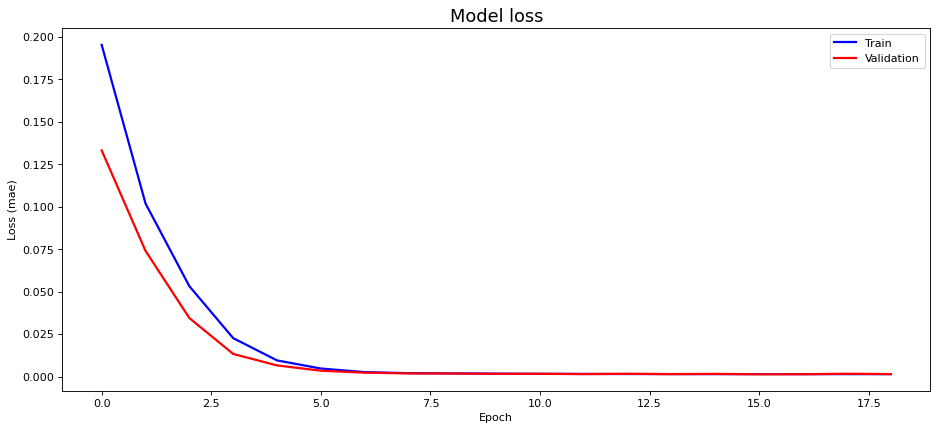

In [14]:
from matplotlib import pyplot as plt

# plot the training losses
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history.history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history.history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

In [15]:
model.save('models/lstm_autoencoder_model.h5') 

### **Calcular threshold**

In [23]:
from tensorflow.keras.models import load_model

model = load_model('models/lstm_autoencoder_model.h5')
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_16 (LSTM)               (None, 832, 8)            1216      
_________________________________________________________________
lstm_17 (LSTM)               (None, 4)                 208       
_________________________________________________________________
repeat_vector_4 (RepeatVecto (None, 832, 4)            0         
_________________________________________________________________
lstm_18 (LSTM)               (None, 832, 4)            144       
_________________________________________________________________
lstm_19 (LSTM)               (None, 832, 8)            416       
_________________________________________________________________
time_distributed_4 (TimeDist (None, 832, 29)           261       
Total params: 2,245
Trainable params: 2,245
Non-trainable params: 0
____________________________________________________

In [24]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# load
train = pd.read_csv('Z:\\Descargas\\composite\\deepl\\train_correct.csv')

# normalize
scaler = MinMaxScaler().fit(train)
train = scaler.transform(train)

# reshape
n_samples = 5007
n_steps = 832
n_features = train.shape[1]
train = train.reshape((n_samples, n_steps, n_features))

# predict
pred_train = model.predict(train)
pred_train.shape

(5007, 832, 29)

In [27]:
import numpy as np
mean = np.mean(np.abs(pred_train-train), axis=2)
print(mean.shape)
mean = np.mean(mean, axis=1)
print(mean.shape)

threshold = mean.mean()+3*mean.std()
threshold

(5007, 832)
(5007,)


0.0009641615206950865

In [19]:
import numpy as np
import pandas as pd
from glob import glob

files = glob('Z:\Descargas\composite\deepl\CSV_DATA_RESAMPLED\*.csv')
np.random.shuffle(files)

n_files = int(len(files) * 0.5) # 15% de los datos incorrectos

df_list = []

for file in files:
    df = pd.read_csv(file)
    if df.iloc[:,-1][0] == 0:
        df_list.append(df)
    if len(df_list) == n_files:
        break
        
print(len(df_list))

4959


In [20]:
test = pd.concat(df_list)
test = test.iloc[:,:-1]

test = scaler.transform(test)
test = test.reshape((4959, n_steps, n_features))

pred_test = model.predict(test)

In [21]:
draw_train = np.mean(np.abs(pred_train-train), axis=1)
draw_train = np.mean(draw_train, axis=1)

draw_test = np.mean(np.abs(pred_test-test), axis=1)
draw_test = np.mean(draw_test, axis=1)

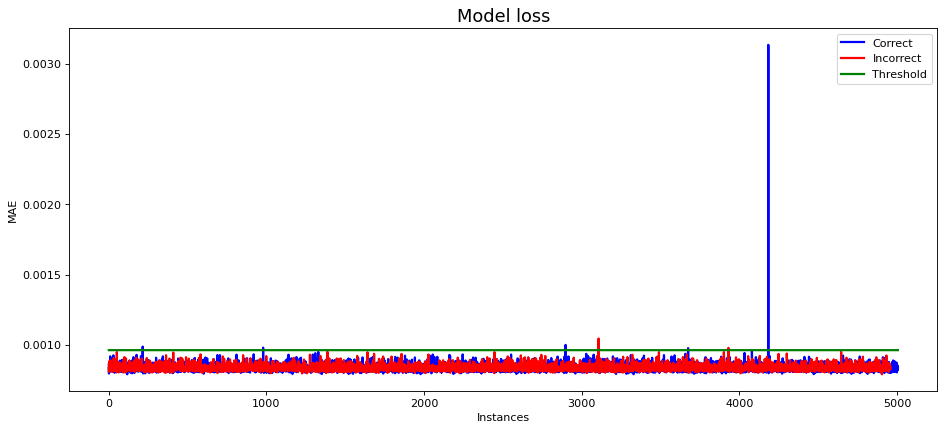

In [22]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(draw_train, 'b', label='Correct', linewidth=2)
ax.plot(draw_test, 'r', label='Incorrect', linewidth=2)
ax.plot(np.full(shape=5007, fill_value=threshold), 'g', label='Threshold', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('MAE')
ax.set_xlabel('Instances')
ax.legend(loc='upper right')
plt.show()